In [2]:
# Python program to create 
# Image Classifier using CNN 

# Importing the required libraries 
import cv2 
import os 
import numpy as np 
from random import shuffle 
from tqdm import tqdm 

'''Setting up the env'''


'Setting up the env'

In [3]:

TRAIN_DIR = 'train'
TEST_DIR = 'test1'
IMG_SIZE = 50
LR = 1e-3




In [4]:
'''Setting up the model which will help with tensorflow models'''
MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '6conv-basic') 



In [5]:
'''Labelling the dataset'''
def label_img(img): 
	word_label = img.split('.')[-3] 
	# DIY One hot encoder 
	if word_label == 'cat': return [1, 0] 
	elif word_label == 'dog': return [0, 1] 



In [6]:
'''Creating the training data'''
def create_train_data(): 
	# Creating an empty list where we should the store the training data 
	# after a little preprocessing of the data 
	training_data = [] 

	# tqdm is only used for interactive loading 
	# loading the training data 
	for img in tqdm(os.listdir(TRAIN_DIR)): 

		# labeling the images 
		label = label_img(img) 

		path = os.path.join(TRAIN_DIR, img) 

		# loading the image from the path and then converting them into 
		# greyscale for easier covnet prob 
		img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 

		# resizing the image for processing them in the covnet 
		img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) 

		# final step-forming the training data list with numpy array of the images 
		training_data.append([np.array(img), np.array(label)]) 

	# shuffling of the training data to preserve the random state of our data 
	shuffle(training_data) 

	# saving our trained data for further uses if required 
	np.save('train_data.npy', training_data) 
	return training_data 



In [7]:
'''Processing the given test data'''
# Almost same as processing the traning data but 
# we dont have to label it. 
def process_test_data(): 
	testing_data = [] 
	for img in tqdm(os.listdir(TEST_DIR)): 
		path = os.path.join(TEST_DIR, img) 
		img_num = img.split('.')[0] 
		img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
		img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) 
		testing_data.append([np.array(img), img_num]) 
		
	shuffle(testing_data) 
	np.save('test_data.npy', testing_data) 
	return testing_data 


In [8]:

'''Running the training and the testing in the dataset for our model'''
train_data = create_train_data() 
test_data = process_test_data() 



100%|██████████| 12500/12500 [01:17<00:00, 162.26it/s]


In [9]:
# train_data = np.load('train_data.npy') 
# test_data = np.load('test_data.npy') 
'''Creating the neural network using tensorflow'''
# Importing the required libraries 
import tflearn 
from tflearn.layers.conv import conv_2d, max_pool_2d 
from tflearn.layers.core import input_data, dropout, fully_connected 
from tflearn.layers.estimator import regression 



W0717 20:10:03.573524 140632683738944 deprecation_wrapper.py:119] From /home/rohitbhalerao/anaconda3/lib/python3.7/site-packages/tflearn/helpers/summarizer.py:9: The name tf.summary.merge is deprecated. Please use tf.compat.v1.summary.merge instead.

W0717 20:10:03.587445 140632683738944 deprecation_wrapper.py:119] From /home/rohitbhalerao/anaconda3/lib/python3.7/site-packages/tflearn/helpers/trainer.py:25: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.

W0717 20:10:03.838390 140632683738944 deprecation_wrapper.py:119] From /home/rohitbhalerao/anaconda3/lib/python3.7/site-packages/tflearn/collections.py:13: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0717 20:10:03.976870 140632683738944 deprecation_wrapper.py:119] From /home/rohitbhalerao/anaconda3/lib/python3.7/site-packages/tflearn/config.py:123: The name tf.get_collection is deprecated. Please use tf.compat.v1.get_collection instead.

W0717 20:1

In [20]:
import tensorflow as tf 
tf.reset_default_graph() 
convnet = input_data(shape =[None, IMG_SIZE, IMG_SIZE, 1], name ='input') 

convnet = conv_2d(convnet, 32, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 

convnet = conv_2d(convnet, 64, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 

convnet = conv_2d(convnet, 128, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 

convnet = conv_2d(convnet, 64, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 

convnet = conv_2d(convnet, 32, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 

convnet = fully_connected(convnet, 1024, activation ='relu') 
convnet = dropout(convnet, 0.8) 

convnet = fully_connected(convnet, 2, activation ='softmax') 
convnet = regression(convnet, optimizer ='adam', learning_rate = LR, 
	loss ='categorical_crossentropy', name ='targets') 



In [21]:
model = tflearn.DNN(convnet, tensorboard_dir ='log') 

# Splitting the testing data and training data 
train = train_data[:-500] 
test = train_data[-500:] 




In [12]:
'''Setting up the features and lables'''
# X-Features & Y-Labels 

X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) 
Y = [i[1] for i in train] 
test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) 
test_y = [i[1] for i in test] 



In [13]:
'''Fitting the data into our model'''
# epoch = 5 taken 
model.fit({'input': X}, {'targets': Y}, n_epoch = 5, 
	validation_set =({'input': test_x}, {'targets': test_y}), 
	snapshot_step = 500, show_metric = True, run_id = MODEL_NAME) 
model.save(MODEL_NAME) 



Training Step: 1914  | total loss: 0.38004 | time: 58.036s
| Adam | epoch: 005 | loss: 0.38004 - acc: 0.8252 -- iter: 24448/24500
Training Step: 1915  | total loss: 0.37686 | time: 59.197s
| Adam | epoch: 005 | loss: 0.37686 - acc: 0.8255 | val_loss: 0.48599 - val_acc: 0.7720 -- iter: 24500/24500
--


In [14]:
'''Testing the data'''
import matplotlib.pyplot as plt 
# if you need to create the data: 
# test_data = process_test_data() 
# if you already have some saved: 
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
test_data = np.load('test_data.npy') 

fig = plt.figure() 



<Figure size 432x288 with 0 Axes>

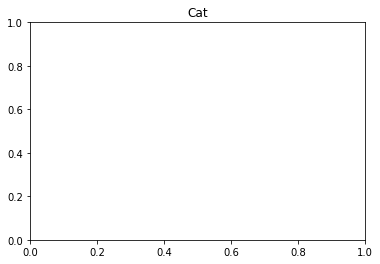

In [15]:
for num, data in enumerate(test_data[:20]): 
	# cat: [1, 0] 
	# dog: [0, 1] 
	
	img_num = data[1] 
	img_data = data[0] 
	
	y = fig.add_subplot(4, 5, num + 1) 
	orig = img_data 
	data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1) 

	# model_out = model.predict([data])[0] 
	model_out = model.predict([data])[0] 
	
	if np.argmax(model_out) == 1: str_label ='Dog'
	else: str_label ='Cat'
		
	y.imshow(orig, cmap ='gray') 
	plt.title(str_label) 
	y.axes.get_xaxis().set_visible(False) 
	y.axes.get_yaxis().set_visible(False) 
plt.show() 

In [16]:
saver = tf.train.Saver()

In [22]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

W0717 21:20:09.903237 140632683738944 deprecation.py:323] From /home/rohitbhalerao/anaconda3/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


model loaded!
